# FISCAS
***

## Introduction

This python based program can be used to combine MALDI imaging data with microscope images to: 
1. overlay maldi images with microscope images 
2. perform a cell segmentation (based on Cellprofiler)
3. calculate single cell mass spectra based on the previous 2 steps

To do so in a user friendly environment this program is implented in Jupyter-lab. 

"JupyterLab is the latest web-based interactive development environment for notebooks, code, and data. Its flexible interface allows users to configure and arrange workflows in data science, scientific computing, computational journalism, and machine learning." --- jupyter.org

Jupyter-Lab is easy to use even without any programming experience. The interactive environment makes an intuitive workflow possible and minimizes running time while testing different run settings.
A Jupyter Notebook is splitted into many chunks called cells. These cells can either contain text (like this one here) or code. 
To run the program you can simply run one cell after the other by clicking the run button ▶️ or hitting `shift + enter` on the keyboard. By doing so you tell the program to run the current cell and move to the next one. The current cell is indicated by a vertical blue line on the left of the cell. You can also run multiple cells consecutively by marking multiple cells and hitting the run button. Every code cell has quare brackets in the upper left corner `[]`. The brackets are empty if the cell hasn't been run before. Once you run a cell a little asterisk `*` appears in the brackets to indicate that the cell is running. Once it is done, the asterisk is replaced by a consecutive number. One thing to note is that all variables of the program are stored in the random-access memory (RAM) of your system. Depending on your image sizes this can take up a lot of the systems memory. The occupied memory won't be freed until you either shut down Jupyter Notebook, or restart the kernel. You can do so under the Kernel tab in the upper left corner of your browser.  

So let's try to import all the required packages the program needs, by running the first code cell. 

### Import

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
import timeit
import time
from ipywidgets import interact
from ipywidgets import widgets
import os
import pathlib
import pandas as pd
from datetime import datetime
import datetime


#specific imports
import skimage
import skimage.filters as filters
from skimage.transform import resize
import scipy
from scipy.ndimage import rotate
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
import cv2
from PIL import Image
from PIL import ImageOps
import imageio
import seaborn as sns
from tqdm import tqdm
from scipy.sparse import csr_matrix
import mplcursors
from IPython.display import display, HTML

try:
    import cellprofiler_core.pipeline
    import cellprofiler_core.preferences
    import cellprofiler_core.utilities.java
    import cellprofiler.modules
except:
    print("failed to import cellprofiler_core")
    pass
try:
    from pyimzml.ImzMLParser import ImzMLParser, getionimage
except:
    print("failed to import pyimzml")
    pass
try:
    from scilslab import LocalSession 
    import scilslab
except:
    print("failed to import SCiLS API")
    pass 

print("all modules imported successfully")
print("\n Congratulations, you did it!")


Bad key text.latex.preview in file D:\Jan\fiscas\fiscas_venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\Jan\fiscas\fiscas_venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\Jan\fiscas\fiscas_venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You pr

failed to import cellprofiler_core
all modules imported successfully

 Congratulations, you did it!


Let's do it again. The next cells are just for good looking of the tables and graphs and some minor definitions for the rest of the program 😉

In [2]:
%%html
<style>
    table{float:left}
</style>

In [3]:
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
%matplotlib widget

In [5]:
java_vm = False
Image.MAX_IMAGE_PIXELS = 1000000000

Now lets define the paths to your images. Feel free to replace some of these paths according to your own data. For the import you have three different options (.csv, .slx, .imzml) so you don't need to provide path variables for all of them.
The microscope images should be as large as necessary (enclosing the maldi image) and as small as possible to reduce memory usage and runtime. 
The following table contains the abbreviations used for the variable names of the path variables. On the bottom of the document is a complete list with all abbreviations used in the program.

| abbreviation | long form |
| :- | :- |
| bf | bright field |
| mem | membrane |
| nuc | nuc |
| lic | license (SCiLS) |
| pipe | pipeline (Cellprofiler) |
| dir | directory |

In [6]:
# Directories and variables
output_dir = os.path.abspath("./results/") # directory in which all results will be saved
input_dir = os.path.abspath("./data/") # directory where all the needed files are

# Cellprofiler 
pipe_dir = input_dir + "/Pipe_3.cppipe"
plugin_dir = os.path.abspath(r"./../../fiscas_venv/Lib/site-packages/cellprofiler/modules/plugins")
# paths to files
path_bf = input_dir + "/THP_P16_ch3_bf.tif"
path_mem = input_dir + "/THP_P16_ch3_wga.tif"
path_nuc = input_dir + "/THP_P16_ch3_hoechst.tif"
peak_list = input_dir + "/peakList.csv"

#imzml_import
imzml_file = input_dir + "/s20211121_001_thp-i_pos_c3.imzML"

lic_path = "./lic.txt"
lic = ""
if len(lic)<5:
    try:
        print("reading license from {}".format(lic_path))
        with open(lic_path) as f:
            lines = f.readlines()
            lic =  lines[0]
    except Exception as e:
        print(e)
        print("please provide a valid license")

scils_file = input_dir + "/s20211121_001_THP-I_pos_C3.slx"

#csv_import
path_spots = input_dir + "/c3cutSpots.csv"
path_spectra = input_dir + "/c3cutSpectra.csv"

reading license from ./lic.txt


The next cell start the java virtual machine (VM) in which cellprofiler will run.

In [7]:
# Set-Up Cellprofiler
cellprofiler_core.preferences.set_headless()
cellprofiler_core.preferences.set_plugin_directory(plugin_dir)
# Start the Java VM
if java_vm == False:
    print("starting java virtual machine")
    cellprofiler_core.utilities.java.start_java()
    java_vm = True

NameError: name 'cellprofiler_core' is not defined

### Settings

Now its time to change the program settings accordingly to your own measurement. 
- General settings
    - `um_per_pixel_mic` corresponds to the resolution of the microscope and is measured in µm/pixel
    - `um_per_pixel_ms` is the pixel size of the maldi measurement in µm/pixel
    - `img_res` is the common resolution that all images will be scaled to, to match each other; It is measured in µm 
- Overlay settings
    - `overlay_peak` corresponds to the *m/z* of the maldi image which will be used for the overlay; it should be an intense signal that is homogenously distributed throughout the cells
    - `rotation_overlay` can be turned on to improve the overlay result by rotating the image in a specified range to correct minor rotation differences between the maldi and microscope images
- Single cell mass spectra settings
    - `rim_pixel_correction` can be turned on to scale maldi intensities that only hit cells partially, according to their hit area

In [8]:
# general settings
#um_per_pixel_mic = 0.334992 # resolution of the microscope in micrometer/pixel
um_per_pixel_mic = 0.344 # empirically determined; it delivers better results since it makes up for imprecisions in the MALDI stage; the original value above will work as well just not as good as this one
pixel_area_mic = um_per_pixel_mic * um_per_pixel_mic
um_per_pixel_ms = 8 # resolution of the ms image in micrometer/pixel
img_res = 4 # resolution that is used for scaling the images to a uniform size in micrometer; greatly influences the running time of the overlay

# overlay settings
overlay_peak = 577.5168 # m/z at which the overlay is performed
rotation_overlay = True
rotation_val = 25
if rotation_overlay == True and not rotation_val:
    rotation_val = int(input("rotation_overlay: How many steps should be used for image rotation? (1 step = 0.1 degree)"))


# single cell mass spectra settings
remove_ambiguous = True
mic_scale_factor = um_per_pixel_mic / img_res
ms_scale_factor = um_per_pixel_ms / img_res
ms_to_mic = ms_scale_factor / mic_scale_factor
if ms_scale_factor.is_integer():
    ms_scale_factor = int(ms_scale_factor)
else:
    raise Exception("the img_res must be a common divisor of um_per_pixel_ms")
    

### Functions

Now we need to define all the functions that are used in the program. You can just run these cells one after another. There is no cool output to look at. 

For all programmers who read this you are welcome to look in these functions and tweak them here and there to fit your purpose. If you find any bugs or have suggestions for a more efficient way of solving this, you are very welcome to post them on the corresponding github page.

In [9]:
# function wrapper to measure the time of a function
def time_report(func):
    def wrapper(*args, **kwargs):
        start = timeit.default_timer()
        result = func(*args, **kwargs)
        stop = timeit.default_timer()
        print("Function \"{a}\" took {b} to run".format(a=func.__name__,b=datetime.timedelta(seconds=(stop-start))))
        return result
    return wrapper

In [10]:
# imports MS Data from csv files; spot_file contains pixel ids with x and y coordinates; 
# spectra_file contains m/z and intensities for every pixel; peak_list_file contains an 
# optional peak List which will be used to reduce the mass list;
# returns the mass list and an image with all intensities as numpy arrays

def calculate_idx(x,y,x_min,y_min):
    i = 0
    j = 0
    j = int(np.round((y - y_min)/um_per_pixel_ms)) 
    i = int(np.round((x - x_min)/um_per_pixel_ms))
    return i, j



@time_report
def csv_import(spot_file, spectra_file, peak_list_file=None): 

    x = []
    y = []

    with open(spot_file) as f:
        reader = csv.reader(f, delimiter = ';')
        l = 0
        for row in reader:
            if l > 8:
                x.append(float(row[1]))
                y.append(float(row[2]))
            l = l + 1
        spots = np.zeros(((l-9),3), dtype = int)
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    dx = np.absolute(int(np.round((x_max - x_min)/um_per_pixel_ms))) + 1
    dy = np.absolute(int(np.round((y_max - y_min)/um_per_pixel_ms))) + 1


    with open(spot_file) as f:
        reader = csv.reader(f, delimiter = ';')
        l = 0
        for row in reader:
            if l > 8:            
                x, y = calculate_idx(float(row[1]), float(row[2]), x_min, y_min)
                spots[l-9, 0] = int(l - 9)
                spots[l-9, 1] = x
                spots[l-9, 2] = y
            l = l + 1
    #spots = np.flip(spots, axis=1)
    num_spots = len(spots)
    print("num_spots: {}".format(num_spots))
        
    # creates the mass and intensity list
    with open(spectra_file) as data:
        csv_reader = csv.reader(data, delimiter = ';')
        line = 0
        for row in csv_reader:
            if line == 10:
                mass_list = np.zeros((len(row)-1)) # list with all m/z 
                intensity_list = np.zeros((num_spots,len(row)-1)) # list with intensities of all pixels and all m/z
                for j in range(0, len(row)-1):
                    mass_list[j]=float(row[j+1])
            if line > 10:
                for j in range(0, len(row)-1):
                    intensity_list[line-11,j]=int(row[j+1])
            line += 1

    # shapes the intensity list to the size of the actual image.
    print("len mass list: {}".format(len(mass_list)))
    img_all_int = np.zeros((dy,dx,len(mass_list))) # image with intensities for every m/z for all pixels
    y_max = np.max(spots[2])
    for idx, x, y in spots:
        img_all_int[y_max - y,x,:]=intensity_list[idx,:] 
    
    # reduces the number of peaks by combining neighbouring peaks corresponding to the peak list
    if peak_list_file:
        with open(peak_list_file) as data:
            csv_reader = csv.reader(data, delimiter=';')
            line = 0
            for row in csv_reader:
                line += 1
            length_peak_list = line-9
            
        peak_list = np.zeros((length_peak_list, 2))
        with open(peak_list_file) as data:
            csv_reader = csv.reader(data, delimiter=';')
            line = 0
            for row in csv_reader:
                if line > 8:
                    peak_list[line-9,0] = row[0]
                    peak_list[line-9,1] = row[1]
                line += 1
        
        img_all_comp = np.zeros((dy, dx, len(peak_list)))
        for i in tqdm(range(len(peak_list)), desc='Loading...'):
            j_list = []
            for j in range(i,len(mass_list)):
                if mass_list[j] > (peak_list[i,0] - peak_list[i,1]) and mass_list[j] < (peak_list[i,0] + peak_list[i,1]):
                    j_list.append(j)
            img_all_comp[:,:,i] = np.sum(img_all_int[:,:, j_list[0] : j_list[-1] + 1], axis=2)
        return peak_list[:,0], img_all_comp
            
    return mass_list, img_all_int  

In [11]:
# import MS data directly from scils file
# returns the mass list and an image with all intensities as numpy arrays
# peaklist is here mandatory but if none is given you will be requested to choose one from your scils file
# region is a selector for which region you want to import if multiple are present

@time_report
def scils_import(lic, scils_file, region = None, peaklist_name=None):
    
    # load local SCILS API session
    os.environ["SCILSMSSERVER_LICENSE"] = lic
    with LocalSession(filename = scils_file, auto_migrate_files=True) as session:

        try:
            dataset = session.dataset_proxy
            no_peaklist = True
            no_region = True
            peaklists = dataset.feature_table.get_feature_lists()

            # check if a valid feature list was provided, if not then request feature list
            while no_peaklist:

                if peaklist_name:
                    for i_name, name in enumerate(peaklists.name):
                        if name == peaklist_name:
                            peaklist_id = peaklists.id[i_name]
                            peaklist = dataset.feature_table.get_features(peaklist_id)
                            no_peaklist = False
                    if no_peaklist:
                        peaklist_name = None
            
                else:     
                    print("Available peaklists: \n")
                    for name in peaklists.name:
                        print(name)
            
                    peaklist_name = str(input("\n Enter a valid peaklist to proceed \n"))
            
                    for i_name, name in enumerate(peaklists.name):
                        if name == peaklist_name:
                            peaklist_id = peaklists.id[i_name]
                            peaklist = dataset.feature_table.get_features(peaklist_id)
                            no_peaklist = False

            region_tree = dataset.get_region_tree()
            i=0
            ids=[]

            for element in region_tree.subregions:
                ids.append(element.id)
                print("idx {a}: {b}".format(a=i, b=element.name))
                i += 1
            # check if a valid region was provided, otherwise request valid region
            while no_region:
                if region in ids:
                    no_region = False
                else:
                    region_idx = int(input("please provide a valid idx \n"))
                    region = region_tree.subregions[region_idx].id
                    print("you selected {} \n the corresponding ID is {}".format(region_tree.subregions[region_idx].name, region_tree.subregions[region_idx].id))

            intervals = [interval for interval in zip(peaklist['mz_low'], peaklist['mz_high'])]
            num_of_peaks = len(intervals)
            print("importing {} peaks".format(num_of_peaks))
            mass_list = np.zeros(num_of_peaks, dtype=float)

            # rearrange subregions on a 2d grid 
            index_image_list = dataset.get_index_images(region)
            spots = dataset.get_region_spots(region)
            tmat = dataset.get_index_images(region)[0].transformation
            backtransformation = np.linalg.inv(tmat)[0:2,0:2]
            pixel_indices = np.matmul(list(zip(spots['x'], spots['y'])), backtransformation)
            pixel_indices_int = np.apply_along_axis(lambda x: np.round(x + np.mean(np.round(x) - x)), 0, pixel_indices).astype(int)
            pixel_indices_int = np.apply_along_axis(lambda x: x - np.min(x), 0, pixel_indices_int)
            sparse_matrix = csr_matrix((spots['spot_id'], (pixel_indices_int[:, 1], pixel_indices_int[:, 0])))
            id_img = sparse_matrix.toarray()
            # create array that will contain all regions as well as all intensities of the specified peak list
            img_all_int = np.zeros((len(id_img), len(id_img[0]), num_of_peaks), dtype=float)

            i=0
            # populate mass_list and img_all_int
            for peak in tqdm(intervals, desc='Loading...'):
                output = np.zeros(id_img.shape)
                mass_list[i] = np.mean((peak[0], peak[1]))
                int_image_list = dataset.get_ion_images(peak[0], peak[1], region_id=region)
                for index_image, int_image in zip(index_image_list, int_image_list):
                    try:
                        argument = np.max(index_image.values)
                        y,x = np.unravel_index(np.argmax(index_image.values), index_image.values.shape)
                        glob_y, glob_x = np.where(id_img == argument)[0:2]
                        pos_y = glob_y[0] - y
                        pos_x = glob_x[0] - x
                        output[pos_y : pos_y + len(index_image.values), pos_x : pos_x + len(index_image.values[0])] += np.nan_to_num(int_image.values)
                    except Exception as e:
                        print(e)
                        continue

                img_all_int[:,:,i] =  output
                i += 1
            
            # save results as .npy array
            np.save(output_dir + "/mass_list.npy", mass_list)
            return mass_list, img_all_int
        
        except Exception as e:
            print(str(e))
            return None

In [12]:
# imzml import
# takes the .imzml file and a peaklist in .csv format as input

@time_report
def imzml_import(imzml_file, peaklist_file):
    
    print("starting import")
    try:
        with open(peaklist_file) as data:
            csv_reader = csv.reader(data, delimiter=';')
            line = 0
            for row in csv_reader:
                line += 1
            length_peaklist = line-9
            
        peaklist = np.zeros((length_peaklist, 2))
        with open(peaklist_file) as data:
            csv_reader = csv.reader(data, delimiter=';')
            line = 0
            for row in csv_reader:
                if line > 8:
                    peaklist[line-9,0] = row[0]
                    peaklist[line-9,1] = row[1]
                line += 1
    except Exception as e:
        print(e)
        print("Please provide the path to a valid peaklist.")
   
    p = ImzMLParser(imzml_file)
    img = getionimage(p, peaklist[0][0], tol=peaklist[0][1])
    img_all_int = np.zeros((len(img), len(img[0]), len(peak_list)))
    mass_list = np.zeros(len(peak_list))
    i = 0
    for peak, tolerance in tqdm(peaklist, desc='Loading'):
        img_all_int[:,:,i] = getionimage(p, peak, tol=tolerance)
        mass_list[i] = peak

    return mass_list, img_all_int


In [13]:
# function that coregistrates to images (overlay)
# Takes the smaller image as first argument and the larger image as second argument. 
# Also needs the image resolution of both images and the resolution in micrometer/pixel at which the overlay is performed.
# Returns the coordinates at the position with the highest cross correlation and if a rotation correction was performed also the opitmal rotation value

@time_report
def perform_overlay(ms_img, mic_img, ms_res, mic_res, img_res, rotation_val=0):
    # scale ms img to overlay Resolution
    print("binarizing and scaling images...")
    ms_img_scaled = np.zeros((len(ms_img)*ms_scale_factor,len(ms_img[0])*ms_scale_factor)) 
    for i in range(len(ms_img)):
        for j in range(len(ms_img[0])):
            ms_img_scaled[i*ms_scale_factor:i*ms_scale_factor+ms_scale_factor, 
                          j*ms_scale_factor:j*ms_scale_factor+ms_scale_factor] = ms_img[i,j]
    # scale microscopy img to overlay Resolution
    mic_img_scaled = resize(mic_img, (int(len(mic_img)*mic_scale_factor), int(len(mic_img[0])*mic_scale_factor))) 
    # binarize microscopy and ms img for overlay
    mic_img_thresh = filters.threshold_otsu(mic_img_scaled) 
    mic_img_bin = np.zeros((mic_img_scaled.shape))
    mic_img_bin[mic_img_scaled>mic_img_thresh]=1
    ms_img_thresh = filters.threshold_otsu(ms_img_scaled)
    ms_img_bin = np.zeros((ms_img_scaled.shape))
    ms_img_bin[ms_img_scaled>ms_img_thresh]=1
    
    print("performing overlay...")
    overlay = scipy.signal.correlate2d(mic_img_bin, ms_img_bin, mode='valid', boundary='fill', fillvalue=0)
    y_over, x_over = np.unravel_index(np.argmax(overlay), overlay.shape)
    
    # rotates the image in 0.1 degree steps and optimizes for best 2d correlation
    if rotation_val != 0:
        rot_eval = np.zeros((rotation_val*2 + 1,2))
        overlay_rot_padding = 20
        # use previous overlay as start point for rotation and use only a subset of the microscope image, depending on padding range.
        mic_img_bin_cut = mic_img_bin[y_over - overlay_rot_padding : y_over + len(ms_img_bin) + overlay_rot_padding,
                                     x_over - overlay_rot_padding : x_over + len(ms_img_bin[0]) + overlay_rot_padding]
        rot_opt_value = 0
        rot_opt = 0
        # for loop to calculate 2d correlation for every rotation value
        for rot in tqdm(range(-rotation_val, rotation_val + 1), desc='performing rotation...'):
            ms_img_bin_rot = rotate(ms_img_bin, rot*0.1, reshape=False)
            overlay_rot = scipy.signal.correlate2d(mic_img_bin_cut, ms_img_bin_rot, 
                                                   mode='valid', boundary='fill', fillvalue=0)
            rot_eval[rot + rotation_val, 0] = rot*0.1
            rot_eval[rot + rotation_val, 1] = np.max(overlay_rot)
            if np.max(overlay_rot) > rot_opt_value:
                rot_opt = rot*0.1
                rot_opt_value = np.max(overlay_rot)
        print("optimal Rotation: {}".format(rot_opt))
        # perform final overlay with optimal rotation
        ms_img_bin_unrotated = ms_img_bin
        ms_img_bin = rotate(ms_img_bin, rot_opt, reshape=False)
        overlay = scipy.signal.correlate2d(mic_img_bin, ms_img_bin, mode='valid', boundary='fill', fillvalue=0)
        y_over, x_over = np.unravel_index(np.argmax(overlay), overlay.shape)
        
        # plot rotation evaluation
        plt.figure()
        plt.title("rotation evaluation")
        plt.plot(rot_eval[:,0], rot_eval[:,1], '.')
        plt.savefig(output_dir + "/images/rotation_evaluation.jpg", dpi=300)
        
    # plot results
    overlay_img = np.zeros((len(mic_img_bin), len(mic_img_bin[0]), 3))
    overlay_img[:,:,0] = mic_img_bin
    overlay_img[y_over : y_over + len(ms_img_bin), x_over : x_over + len(ms_img_bin[0]), 1] = ms_img_bin[:,:]     
    plt.figure()
    plt.imshow(overlay)
    plt.title("overlay")
    plt.plot(x_over, y_over, 'r+')
    plt.savefig(output_dir +  "/images/overlay.jpg", dpi=300)
    plt.figure()
    plt.title("binary overlay image")
    plt.imshow(overlay_img)
    plt.savefig(output_dir + "/images/overlay_img.jpg", dpi=300)
    
    if rotation_val != 0:
        results = np.array([x_over, y_over, rot_opt])
        np.save(output_dir + "/overlay_results.npy", results)
        return (x_over, y_over, rot_opt)
    else:
        results = np.array([x_over, y_over])
        np.save(output_dir + "/overlay_results.npy", results)
        return (x_over, y_over)

In [14]:
# Uses Cellprofiler to provide a cell segmentation based on the fluorescence images
# Takes a Cellprofiler pipeline as an input 
# Optional Arguments are the option to overwrite other files (default is yes) and the file format of the output (.npy or .tiff)

@time_report
def cellprofiler_segment(pipe_dir=pipe_dir, overwrite_results='yes', output_file_format='npy'):

    # Open a pipeline
    pipeline = cellprofiler_core.pipeline.Pipeline()
    pipeline.load(pipe_dir)
    # Set output directory
    saving_path = pathlib.Path(output_dir)
    cellprofiler_core.preferences.set_default_output_directory(output_dir)
    print(f"Data will be saved to: {output_dir}")
    #Loading images
    input_path = pathlib.Path(input_dir)
    file_list = list(input_path.glob('*cut.tif'))
    print("Number of images:", len(file_list))
    files = [file.as_uri() for file in file_list]
    print(files)
    pipeline.read_file_list(files)
    # overwrite data
    for module in pipeline.modules():
        if type(module) == cellprofiler.modules.saveimages.SaveImages:
            module.overwrite.set_value('Yes')
            #module.setting(12).set_value(overwrite_results)
            module.setting(9).set_value(output_file_format)
        elif type(module) == cellprofiler.modules.exporttospreadsheet.ExportToSpreadsheet:
            #module.setting(18).set_value(overwrite_results)
            module.wants_overwrite_without_warning.set_value('Yes')

    #Running the pipeline
    output_measurements = pipeline.run()
    
    
    # Load saved images
    color_images = list(saving_path.glob('*Color.npy'))
    WGA_images = list(saving_path.glob('*WGA_label.npy'))
    nuclei_images = list(saving_path.glob('*Nuc_label.npy'))

    cell_marker_cut = np.load(WGA_images[0])
    
    fig, axes = plt.subplots(nrows=1, ncols= 3, figsize=(15, 10))
    axes[0].imshow(np.load(color_images[0]))
    axes[0].set_title("Segmentation")
    axes[1].imshow(cell_marker_cut)
    axes[1].set_title("WGA Label Image")
    axes[2].imshow(np.load(nuclei_images[0])) 
    axes[2].set_title("Nuclei Label Image")
    for ax in axes:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.tight_layout()
    


    cell_marker_scaled_cut = cv2.resize(cell_marker_cut, dsize=(ms_scaled_shape[1], ms_scaled_shape[0]), interpolation=cv2.INTER_NEAREST)
    cell_marker_masked_scaled_cut = np.ma.masked_where(cell_marker_scaled_cut < 0.95, cell_marker_scaled_cut)
    np.savez_compressed(output_dir + "/cell_marker_masked_scaled_cut", data = cell_marker_masked_scaled_cut, mask=cell_marker_masked_scaled_cut.mask)

    plt.figure()
    plt.imshow(cell_marker_masked_scaled_cut)

    return cell_marker_masked_scaled_cut

### Run the program

Now the time has come to actually run the program. Let's start with importing you mass spectra by running one of the next 3 cells. Depending on your data size and the format you import the data from this may take a while. 

#### Import

<div class="alert alert-block alert-warning">
You can import your data via csv files (only tested for csv files generated by SCiLS; t = 37 s), SCiLS files (.slx; t = 21 s) and imzml files (t = 33 min 23 s). The running times were measured with the test sample set of 16993 pixels and 502 mass features. If an .slx file and a SCiLS license is available the SCiLS import is recommended. For the SCiLS import you either need to assign the license number to the variable 'lic' in the sections where the paths are defined, or you need to provide a path to a text file which contains only the license number.   
</div>

In [15]:
# SCiLS import via SCiLS API
# please do not interrupt the kernel during import. If you do, you need to restart the kernel 
# before you can retry to properly close the scils session
# otherwise the file be blocked by the licensing software due to incomplete closing of the prior session 

try: 
    #test if mass_list and ms_img_all_int already exist
    mass_list.shape
    ms_img_all_int.shape
    print("The data is already imported. If you want to reimport, restart the kernel or run the the import seperately.")
except:
    mass_list, ms_img_all_int = scils_import(lic, scils_file)

Available peaklists: 

All Features
500peaks
500peaks_v2



 Enter a valid peaklist to proceed 
 500peaks_v2


idx 0: Regions/s20211121_001_THP-I_pos_C3


please provide a valid idx 
 0


you selected Regions/s20211121_001_THP-I_pos_C3 
 the corresponding ID is 144d9fed-1d46-4d81-a6f9-3a58e0da3b30
importing 502 peaks


Loading...: 100%|████████████████████████████████████████████████████████████████████| 502/502 [00:21<00:00, 23.90it/s]

Function "scils_import" took 0:00:28.346930 to run


In [16]:
# csv import

try:
    #test if mass_list and ms_img_all_int already exist
    mass_list.shape
    ms_img_all_int.shape
    print("The data is already imported. If you want to reimport, restart the kernel or run the the import seperately.")
except:
    mass_list, ms_img_all_int = csv_import(path_spots, path_spectra, peak_list)

The data is already imported. If you want to reimport, restart the kernel or run the the import seperately.


In [17]:
# imzml import via pyimzml
# compared to the other methods very slow

try:
    #test if mass_list and ms_img_all_int already exist
    mass_list.shape
    ms_img_all_int.shape
    print("The data is already imported. If you want to reimport, restart the kernel or run the the import seperately.")
except:
    mass_list, ms_img_all_int = imzml_import(imzml_file, peaklist_file)

The data is already imported. If you want to reimport, restart the kernel or run the the import seperately.


#### Prepare microscope images for overlay

The next step is the import of the microscope images and to adjust their contrast prior to the overlay. This contrast enhancement is needed for the overlay to ensure that the binarization will work. It is done by rescaling the lowest and highest intensities to the minimal and maximal value that is possible (`.rescaling_intensity()`). You can check the results in the cell below. If the results don't look to good or you have some other contrast enhancement method you want to use, feel free to change it. Here are some options from the skimage pack that you could try:
-  `skimage.exposure.rescale_intensity(mem_img)`
-  `skimage.exposure.equalize_hist(mem_img)`
-  `skimage.exposure.equalize_adapthist(mem_img)`
- `skimage.exposure.adjust_gamma(mem_img)`

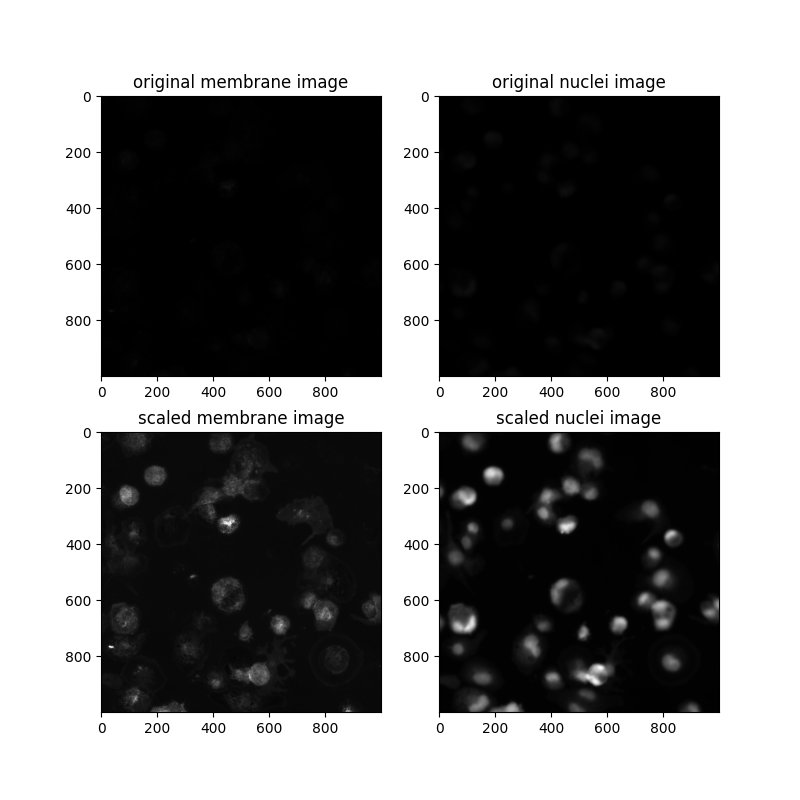

In [18]:
mem_img = imageio.v2.imread(path_mem)
nuc_img = imageio.v2.imread(path_nuc)
bf_img = imageio.v2.imread(path_bf) 
    
mem_img_cont = skimage.exposure.rescale_intensity(mem_img)
nuc_img_cont = skimage.exposure.rescale_intensity(nuc_img)
bf_img_cont = skimage.exposure.rescale_intensity(bf_img)

fix, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(mem_img[:1000,:1000], cmap = 'gray', vmin=0, vmax=65535)
ax[0,0].title.set_text("original membrane image")
ax[0,1].imshow(nuc_img[:1000,:1000], cmap = 'gray', vmin=0, vmax=65535)
ax[0,1].title.set_text("original nuclei image")
ax[1,0].imshow(mem_img_cont[:1000,:1000], cmap = 'gray', vmin=0, vmax=65535)
ax[1,0].title.set_text("scaled membrane image")
ax[1,1].imshow(nuc_img_cont[:1000,:1000], cmap = 'gray', vmin=0, vmax=65535)
ax[1,1].title.set_text("scaled nuclei image")

Now that we are prepared we can run the actual overlay. The next cell generates an image of the `overlay_peak` which you specified above and prints it out on the screen so you can check if you are happy with the distribution for your overlay. The cell after that will then perform the overlay.

#### Overlay

Text(0.5, 1.0, 'm/z 577.5167633602268')

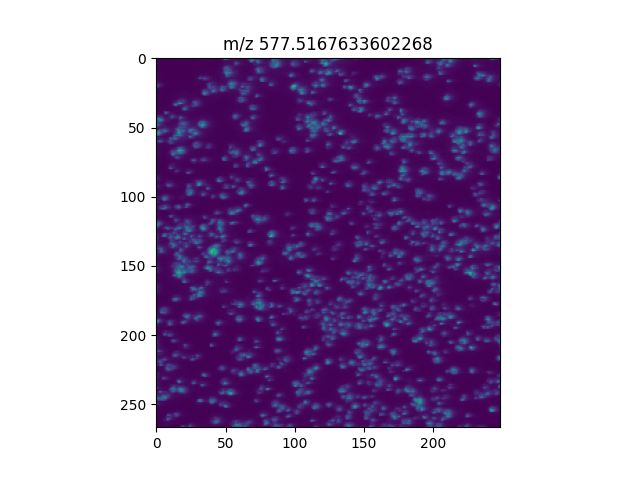

In [20]:
idx_overlay_peak = 0
for i in range(len(mass_list) - 1):
    if abs(mass_list[i+1] - overlay_peak) < abs(mass_list[i] - overlay_peak):
        idx_overlay_peak = i + 1
    else:
        break
        
ms_img = ms_img_all_int[:,:,idx_overlay_peak]
plt.figure()
plt.imshow(ms_img)
plt.title("m/z {}".format(mass_list[idx_overlay_peak]))

<div class="alert alert-block alert-warning">
Depending on your resolution settings and the size of the image the next step can take between a few minutes to several hours so maybe start with a lower resolution (higher values) first and then increase the resolution when you know that everything works.
</div>

binarizing and scaling images...
performing overlay...


performing rotation...: 100%|██████████████████████████████████████████████████████████| 51/51 [13:13<00:00, 15.57s/it]


optimal Rotation: -0.1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Function "perform_overlay" took 4:35:59.331607 to run


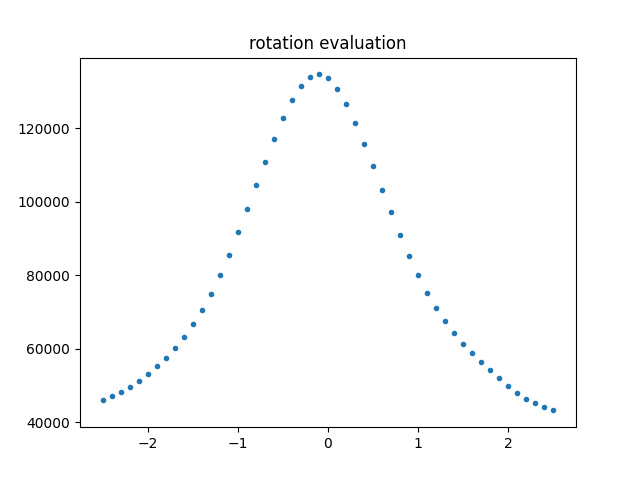

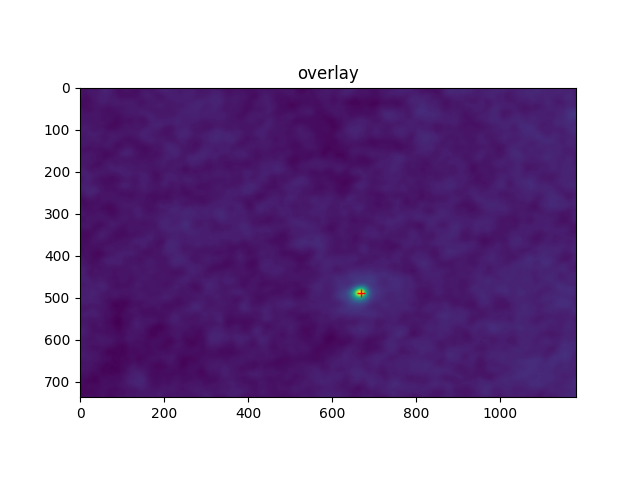

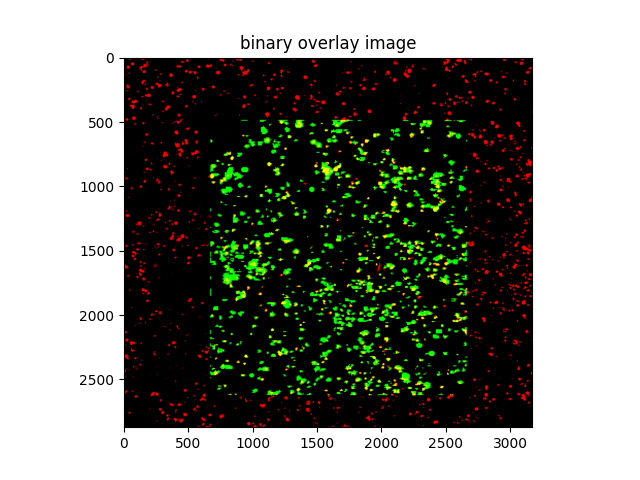

In [22]:
overlay_result = perform_overlay(ms_img, mem_img_cont, um_per_pixel_ms, um_per_pixel_mic, img_res, rotation_val=rotation_val)

What to do if the overlay didn't work at all:
1. Make sure that your maldi image can really be found in your microscopy image
2. Check if the overlay image matches the pattern of your microscopy image (some microscopy images may be flipped compared to the MALDI image)
3. Check if the scaling factors for the maldi resolution and microscopy resolution are correct
4. Turn on the rotation correction for the overlay
5. increase the resolution

If your overlay performed well you can continue with the segmentation.

Since the overlay told us exactly were our MALDI image is positioned on the microscope image we can use only that part for the segmentation. By cutting down the microscope image to the needed size we will reduce memory usage and increase the segmentation speed by a lot. Since we don't want to have any artifacts on the borders we neglect all cells touching the border

In [23]:
mic_scaled_shape = (int(len(mem_img)*mic_scale_factor), int(len(mem_img[0])*mic_scale_factor))
ms_scaled_shape = (int(len(ms_img)*ms_scale_factor), int(len(ms_img[0])*ms_scale_factor))

if rotation_overlay == True:
    mem_img_rot = rotate(mem_img, -overlay_result[2], reshape=False)
    nuc_img_rot = rotate(nuc_img, -overlay_result[2], reshape=False)
    
    mem_img_cut = mem_img_rot[int(overlay_result[1] / mic_scale_factor) : int((overlay_result[1] + ms_scaled_shape[0]) / mic_scale_factor),
                     int(overlay_result[0] / mic_scale_factor) : int((overlay_result[0] + ms_scaled_shape[1]) / mic_scale_factor)
                     ]
    nuc_img_cut = nuc_img_rot[int(overlay_result[1] / mic_scale_factor) : int((overlay_result[1] + ms_scaled_shape[0]) / mic_scale_factor),
                     int(overlay_result[0] / mic_scale_factor)  : int((overlay_result[0] + ms_scaled_shape[1]) / mic_scale_factor)
                     ]

else:

    mem_img_cut = mem_img_cont[int(overlay_result[1] / mic_scale_factor) : int((overlay_result[1] + ms_scaled_shape[0]) / mic_scale_factor),
                         int(overlay_result[0] / mic_scale_factor) : int((overlay_result[0] + ms_scaled_shape[1]) / mic_scale_factor)
                         ]
    nuc_img_cut = nuc_img_cont[int(overlay_result[1] / mic_scale_factor) : int((overlay_result[1] + ms_scaled_shape[0]) / mic_scale_factor),
                         int(overlay_result[0] / mic_scale_factor)  : int((overlay_result[0] + ms_scaled_shape[1]) / mic_scale_factor)
                         ]

im = Image.fromarray(nuc_img_cut)
im.save(input_dir + '/nuc_C2_cut.tif')
im = Image.fromarray(mem_img_cut)
im.save(input_dir + '/mem_C1_cut.tif')

#### Segmentation

The segmentation is performed with Cellprofiler.
Cellprofiler is a very powerfull tool for segmenting and analyzing microscope images of cells. The Standard workflow would be to open Cellprofiler first with a small test image of your cells. Generate a pipeline that is capable of segmenting your testset and saves you all the measurements you want to do on your microscopy images. Then export the pipeline so it can be used by python. If you need any help with using cellprofiler you can find it on https://cellprofiler.org. They have a lot of helpful examples and tutorials to look into and an extensive manual where you can find explantions for all of the functionallity that cellprofiler provides. The important part in the pipeline is that images with `*Color.tif`, `*WGA_label.npy` and `*Nuc_label.npy` are exported, because they will be reopenend and used by the rest of the program. If you change the names in the Cellprofiler pipeline you would need to change them as well in the segmentation function above.

In [24]:
#cell_marker_masked_scaled_cut = cellprofiler_segment()

If you don't want to use cellprofiler for your segmentation and instead use your own segmentation mask you can do so by skipping the cell above and running the next (currently commented) cell. However you may need to adapt it depending of the format the masks are provided in.

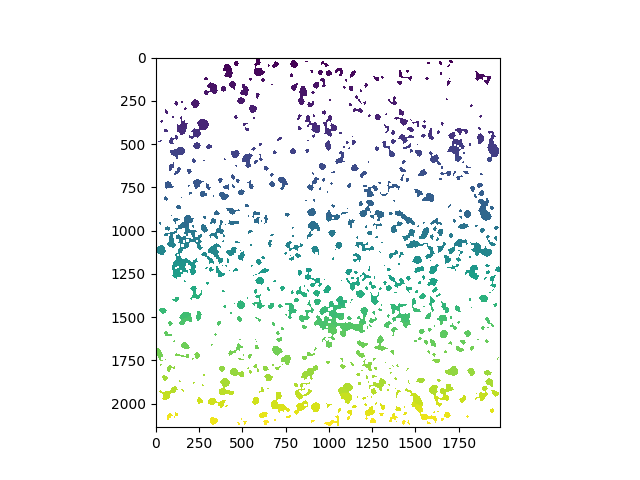

In [25]:
# load mask as .tif
#cell_marker_cut = np.asarray(imageio.v2.imread("path/to/mask.tif"))
# load mask as .npy
cell_marker_cut = np.load(input_dir + "/mem_C1_cutWGA_label.npy")
# scale cell mask to overlay resolution 
cell_marker_scaled_cut = cv2.resize(cell_marker_cut, dsize=(ms_scaled_shape[1], ms_scaled_shape[0]), interpolation=cv2.INTER_NEAREST)
cell_marker_masked_scaled_cut = np.ma.masked_where(cell_marker_scaled_cut < 0.95, cell_marker_scaled_cut)
# save compressed version of cell masks
np.savez_compressed(output_dir + "/cell_marker_masked_scaled_cut", data = cell_marker_masked_scaled_cut, mask=cell_marker_masked_scaled_cut.mask)

plt.figure()
plt.imshow(cell_marker_masked_scaled_cut)

#### Exploratory Data Analysis
Uncomment the next cell to print the results of the morphological analysis

In [26]:
'''
files = []
for filename in os.listdir(output_dir):
    if filename.endswith(".csv"): 
        files.append(os.path.join(output_dir, filename))
        print(filename)
# Experiment.csv contains key:value pairs about the analysis pipeline (CP version, imagetypes)
experiment = pd.read_csv(files[0], delimiter=",", encoding_errors="ignore")
experiment.head(2)
# Image.csv contains measurements on all analysed images (cell counts, execution times, image dimensions )
image = pd.read_csv(files[1], delimiter=",", encoding_errors="ignore")
print(image.shape)
image.head(2)
# Nuclei_Seg_Filtered.csv.csv contains measurements on all analysed objects nuclei (area etc)
nuclei_seg = pd.read_csv(files[3], delimiter=",", encoding_errors="ignore")
print(nuclei_seg.shape)
nuclei_seg.head(2)
# WGA_Seg_Filtered.csv contains measurements on all analysed objects cells (area etc)
wga_seg = pd.read_csv(files[6], delimiter=",", encoding_errors="ignore")
print(wga_seg.shape)
wga_seg.head(2)
# RelateObjects.csv contains Idkw
rel_obj = pd.read_csv(files[4], delimiter=",", encoding_errors="ignore")
print(rel_obj.shape)
rel_obj.head(2)
image.iloc[:, 0:4].describe()
for i in image.iloc[:, 0:4]:
    sns.violinplot(y=image[i], data=image)
    sns.swarmplot(y=image[i], data=image, color="white")
    plt.show()
#Selected measurements
col_plot = ["AreaShape_Area", "AreaShape_Compactness", "AreaShape_ConvexArea", "AreaShape_Eccentricity", "AreaShape_FormFactor", 
"AreaShape_MaximumRadius", "AreaShape_MeanRadius", "AreaShape_MedianRadius", "AreaShape_MinFeretDiameter", 
"AreaShape_MinorAxisLength", "AreaShape_Orientation", "AreaShape_Perimeter", "AreaShape_Solidity"]

#View all measurements with: 
#print(output_measurements.get_measurement_columns())
for i in col_plot:
    print(i)
    sns.violinplot(y=wga_seg[i], data=wga_seg)
    plt.show()
'''

'\nfiles = []\nfor filename in os.listdir(output_dir):\n    if filename.endswith(".csv"): \n        files.append(os.path.join(output_dir, filename))\n        print(filename)\n# Experiment.csv contains key:value pairs about the analysis pipeline (CP version, imagetypes)\nexperiment = pd.read_csv(files[0], delimiter=",", encoding_errors="ignore")\nexperiment.head(2)\n# Image.csv contains measurements on all analysed images (cell counts, execution times, image dimensions )\nimage = pd.read_csv(files[1], delimiter=",", encoding_errors="ignore")\nprint(image.shape)\nimage.head(2)\n# Nuclei_Seg_Filtered.csv.csv contains measurements on all analysed objects nuclei (area etc)\nnuclei_seg = pd.read_csv(files[3], delimiter=",", encoding_errors="ignore")\nprint(nuclei_seg.shape)\nnuclei_seg.head(2)\n# WGA_Seg_Filtered.csv contains measurements on all analysed objects cells (area etc)\nwga_seg = pd.read_csv(files[6], delimiter=",", encoding_errors="ignore")\nprint(wga_seg.shape)\nwga_seg.head(2)\n

#### Single Cell Mass spectra Calculation
The next step will sort out any pixels that hit more than one cell and if the `rim_pixel_correction` is set to `True` it will also scale the signal intensities of pixels that only hit the cell partially, according to the hit area.  

In [27]:
mask_max = np.max(cell_marker_masked_scaled_cut)
mask_min = np.min(cell_marker_masked_scaled_cut)
num_cells = mask_max - mask_min + 2
cells = np.zeros((num_cells, len(mass_list)))
print(cells.shape)
# iterate through all MALDI Pixel
for i in tqdm(range(len(ms_img))):
    for j in range(len(ms_img[0])):
        # sub_region contains the indices of all cells within the current pixel
        sub_region = cell_marker_masked_scaled_cut[(i*ms_scale_factor):((i+1)*ms_scale_factor), (j*ms_scale_factor):((j+1)*ms_scale_factor)]
        # check if there actually is a mask on that pixel, otherwise the user gets notified which pixels are empty
        if len(sub_region) == 0:
            print("empty_region")
            print(i*ms_scale_factor)
            print(j*ms_scale_factor)
        
        # set of cell ids within the current MALDI pixel
        pre_ids = np.unique(sub_region)
        ids = pre_ids[np.nonzero(pre_ids)]
        if len(ids) > 1:
            # if remove_ambiguous is false each pixel that hits multiple cells will be scaled and assigned to the cells based on the hit coverage of their masks
            # if remove_amibguous is True pixels that touch multiple cells will be discarded
            if remove_ambiguous == False:
                for cell_id in ids:
                    area = np.count_nonzero(sub_region == cell_id) / (ms_scale_factor*ms_scale_factor)#np.count_nonzero(sub_region)
                    cells[cell_id, :] += ms_img_all_int[i,j,:] * area
        
        # if the pixel hits only one cell the pixel will be completely assigned to the cell
        if len(ids) == 1:
            for cell_id in ids:
                cells[cell_id,:] += ms_img_all_int[i,j,:]

#save the results as npy. array and as .csv
np.save(output_dir + "/cells", cells)
with open (output_dir + "/cells.csv", 'w') as file:
    writer = csv.writer(file)
    writer.writerows(cells)
    
print("Job Done!")

(995, 502)


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:07<00:00, 36.33it/s]


Job Done!


In [28]:
#Stopping the Java VM
if java_vm == True:
    cellprofiler_core.utilities.java.stop_java()
    java_vm = False

#### Cell picker

15

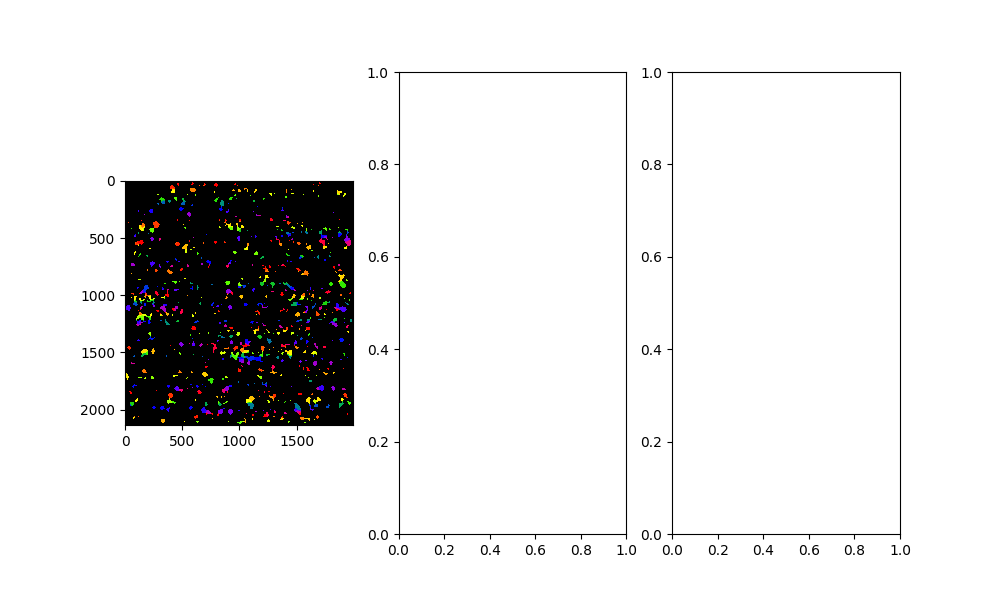

In [29]:
try:
    len(cell_marker_masked_scaled_cut)
except:
    with np.load(output_dir + "/cell_marker_masked_scaled_cut.npz") as npz:
        cell_marker_masked_scaled_cut = np.ma.MaskedArray(**npz)

fig, ax = plt.subplots(1,3,figsize=(10,6)) #necessary, to get mouse events
cmap = copy.copy(plt.cm.prism)
cmap.set_bad(color='black')
im1 = ax[0].imshow(cell_marker_masked_scaled_cut, cmap=cmap, picker=True)
text = ax[0].text(-10,-10,"", va='bottom', ha='left')
bf_img_scaled = resize(bf_img, (int(len(bf_img)*mic_scale_factor), int(len(bf_img[0])*mic_scale_factor)))
#bf_img_scaled = bf_img_cut
bf_img_scaled_color = np.zeros((len(bf_img_scaled), len(bf_img_scaled[0]), 3), dtype='int')
bf_img_255 = np.uint8((bf_img_scaled / np.max(bf_img_scaled) * 255))
bf_img_scaled_color[:,:,0] = bf_img_255
bf_img_scaled_color[:,:,1] = bf_img_255
bf_img_scaled_color[:,:,2] = bf_img_255



def onpick(event):
    mouseevent = event.mouseevent
    x = int(mouseevent.xdata)
    y = int(mouseevent.ydata)

    cell_id = cell_marker_masked_scaled_cut[y,x]
    txt = "x: {}, y: {}, id: {}".format(x, y, cell_marker_masked_scaled_cut[y,x])
    text.set_text(txt)
    marked_cell_img = np.zeros((80,80,3))
    marked_cell_img = bf_img_scaled_color[int(overlay_result[1]+y-40) : int(overlay_result[1]+y+40), int(overlay_result[0]+x-40) : int(overlay_result[0]+x+40)]
    cell_marker_masked_scaled_cellPickerCut = cell_marker_masked_scaled_cut[(y-40) : (y+40), (x-40) : (x+40)]
    cell_picker_img = copy.copy(marked_cell_img)
    cell_picker_img[tuple([cell_marker_masked_scaled_cellPickerCut == (cell_id), 0])] = 0
    #cell_picker_img[tuple([cell_marker_masked_scaled_cellPickerCut == (cell_id), 1])] = 0
    #cell_picker_img[tuple([cell_marker_masked_scaled_cellPickerCut == (cell_id), 2])] = 0
    ax[1].clear()
    ax[1].imshow(cell_picker_img)
    ax[2].clear()
    data = cells[int(cell_id)]
    ax[2].vlines(mass_list,0 , data)
    ax[2].ticklabel_format(axis = 'y', style='sci', scilimits=(0,3))
    cursor = mplcursors.cursor(ax[2]) 
        
    @cursor.connect("add")
    def on_add(sel):
        index = sel.target.index
        mz_value = sel.target[0]
        intensity = data[sel.index[0]]
        text.set_text(index)
        sel.annotation.set_text("mz_value: {:.2f} \n intensity: {:.4f}".format(mz_value, intensity))
fig.canvas.mpl_connect('pick_event', onpick)

## Appendix

### Variable name disclaimer

| abbreviation | long form |
| :- | :- | 
| ms | mass spectrometry | 
| img | image |
| mic | microscopy |
| res | resolution |
| um | micrometer |
| rot | rotation |
| opt | optimum |
| val | value |
| eval | evaluation |
| nuc | nuclear |
| mem | membrane |
| bf | brightfield |
|thresh | threshold |
|cut | cut |
|bin | binarized |
|blur | blurred |
|pos | positions |
|dil | dilated |
|bg | Background |
|fg | foreground |
|seg | segmentation |
|num | number |
|act | actual |
|comp | compressed |
|corr | corrected |
|dc | deepcell |